# Problem 1: Basics of Neural Networks
* <b>Learning Objective:</b> In the entrance exam, we asked you to implement a K-NN classifier to classify some tiny images extracted from CIFAR-10 dataset. Probably many of you noticed that the performances were quite bad. In this problem, you are going to implement a basic multi-layer fully connected neural network to perform the same classification task.
* <b>Provided Code:</b> We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* <b>TODOs:</b> You are asked to implement the forward passes and backward passes for standard layers and loss functions, various widely-used optimizers, and part of the training procedure. And finally we want you to train a network from scratch on your own.

In [1]:
from lib.fully_conn import *
from lib.layer_utils import *
from lib.grad_check import *
from lib.datasets import *
from lib.optim import *
from lib.train import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading the data (CIFAR-10)
Run the following code block to load in the properly splitted CIFAR-10 data.

In [2]:
data = CIFAR10_data()
for k, v in data.iteritems():
    print "Name: {} Shape: {}".format(k, v.shape)

Name: data_train Shape: (49000, 3, 32, 32)
Name: data_val Shape: (1000, 3, 32, 32)
Name: data_test Shape: (1000, 3, 32, 32)
Name: labels_train Shape: (49000,)
Name: labels_val Shape: (1000,)
Name: labels_test Shape: (1000,)


## Implement Standard Layers
You will now implement all the following standard layers commonly seen in a fully connected neural network. Please refer to the file layer_utils.py under the directory lib. Take a look at each class skeleton, and we will walk you through the network layer by layer. We provide results of some examples we pre-computed for you for checking the forward pass, and also the gradient checking for the backward pass.

## FC Forward
In the class skeleton "fc", please complete the forward pass in function "forward", the input to the fc layer may not be of dimension (batch size, features size), it could be an image or any higher dimensional data. Make sure that you handle this dimensionality issue. 

In [3]:
# Test the fc forward function
input_bz = 3
input_dim = (6, 5, 4)
output_dim = 4

input_size = input_bz * np.prod(input_dim)
weight_size = output_dim * np.prod(input_dim)

single_fc = fc(np.prod(input_dim), output_dim, init_scale=0.02, name="fc_test")

x = np.linspace(-0.1, 0.5, num=input_size).reshape(input_bz, *input_dim)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_dim), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

single_fc.params[single_fc.w_name] = w
single_fc.params[single_fc.b_name] = b

out = single_fc.forward(x)
correct_out = np.array([[0.70157129, 0.83483484, 0.96809839, 1.10136194],
                        [1.86723094, 2.02561647, 2.18400199, 2.34238752],
                        [3.0328906,  3.2163981,  3.3999056,  3.5834131]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print "Difference: ", rel_error(out, correct_out)

Difference:  2.48539291792e-09


## FC Backward
Please complete the function "backward" as the backward pass of the fc layer. Follow the instructions in the comments to store gradients into the predefined dictionaries in the attributes of the class. Parameters of the layer are also stored in the predefined dictionary.

In [4]:
# Test the fc backward function
x = np.random.randn(10, 2, 2, 3)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(10, 10)

single_fc = fc(np.prod(x.shape[1:]), 10, init_scale=5e-2, name="fc_test")
single_fc.params[single_fc.w_name] = w
single_fc.params[single_fc.b_name] = b

dx_num = eval_numerical_gradient_array(lambda x: single_fc.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_fc.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_fc.forward(x), b, dout)

out = single_fc.forward(x)
dx = single_fc.backward(dout)
dw = single_fc.grads[single_fc.w_name]
db = single_fc.grads[single_fc.b_name]

# The error should be around 1e-10
print "dx Error: ", rel_error(dx_num, dx)
print "dw Error: ", rel_error(dw_num, dw)
print "db Error: ", rel_error(db_num, db)

dx Error:  7.54356082186e-09
dw Error:  2.17567741378e-08
db Error:  2.10890704929e-11


## ReLU Forward
In the class skeleton "relu", please complete the forward pass.

In [5]:
# Test the relu forward function
x = np.linspace(-1.0, 1.0, num=12).reshape(3, 4)
relu_f = relu(name="relu_f")

out = relu_f.forward(x)
correct_out = np.array([[0.,          0.,        0.,         0.        ],
                        [0.,          0.,        0.09090909, 0.27272727],
                        [0.45454545, 0.63636364, 0.81818182, 1.        ]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-8
print "Difference: ", rel_error(out, correct_out)

Difference:  5.00000005012e-09


## ReLU Backward
Please complete the backward pass of the class relu.

In [6]:
# Test the relu backward function
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
relu_b = relu(name="relu_b")

dx_num = eval_numerical_gradient_array(lambda x: relu_b.forward(x), x, dout)

out = relu_b.forward(x)
dx = relu_b.backward(dout)

# The error should not be larger than 1e-10
print "dx Error: ", rel_error(dx_num, dx)

dx Error:  3.27560123162e-12


## Dropout Forward
In the class "dropout", please complete the forward pass. Remember that the dropout is only applied during training phase, you should pay attention to this while implementing the function.

In [7]:
x = np.random.randn(100, 100) + 5.0

print "----------------------------------------------------------------"
for p in [0.25, 0.50, 0.75]:
    dropout_f = dropout(p)
    out = dropout_f.forward(x, True)
    out_test = dropout_f.forward(x, False)

    print "Dropout p = ", p
    print "Mean of input: ", x.mean()
    print "Mean of output during training time: ", out.mean()
    print "Mean of output during testing time: ", out_test.mean()
    print "Fraction of output set to zero during training time: ", (out == 0).mean()
    print "Fraction of output set to zero during testing time: ", (out_test == 0).mean()
    print "----------------------------------------------------------------"

----------------------------------------------------------------
Dropout p =  0.25
Mean of input:  4.99748683134
Mean of output during training time:  3.73014453649
Mean of output during testing time:  4.99748683134
Fraction of output set to zero during training time:  0.2544
Fraction of output set to zero during testing time:  0.0
----------------------------------------------------------------
Dropout p =  0.5
Mean of input:  4.99748683134
Mean of output during training time:  2.52889278744
Mean of output during testing time:  4.99748683134
Fraction of output set to zero during training time:  0.4939
Fraction of output set to zero during testing time:  0.0
----------------------------------------------------------------
Dropout p =  0.75
Mean of input:  4.99748683134
Mean of output during training time:  1.27664388951
Mean of output during testing time:  4.99748683134
Fraction of output set to zero during training time:  0.7448
Fraction of output set to zero during testing time:  0.0

## Dropout Backward
Please complete the backward pass. Again remember that the dropout is only applied during training phase, handle this in the backward pass as well.

In [8]:
x = np.random.randn(5, 5) + 5
dout = np.random.randn(*x.shape)

p = 0.75
dropout_b = dropout(p, seed=100)
out = dropout_b.forward(x, True)
dx = dropout_b.backward(dout)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_b.forward(xx, True), x, dout)

# The error should not be larger than 1e-9
print 'dx relative error: ', rel_error(dx, dx_num)

dx relative error:  1.89289237658e-11


## Testing cascaded layers: FC + ReLU
Please find the TestFCReLU function in fully_conn.py under lib directory. <br />
You only need to complete few lines of code in the TODO block. <br />
Please design an FC --> ReLU two-layer-mini-network where the parameters of them match the given x, w, and b <br />
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively. <br />
Here you only modify the param_name part, the _w, and _b are automatically assigned during network setup 

In [9]:
x = np.random.randn(2, 3, 4)  # the input features
w = np.random.randn(12, 10)   # the weight of fc layer
b = np.random.randn(10)       # the bias of fc layer
dout = np.random.randn(2, 10) # the gradients to the output, notice the shape

tiny_net = TestFCReLU()

tiny_net.net.assign("fc_test1_w", w)
tiny_net.net.assign("fc_test1_b", b)

out = tiny_net.forward(x)
dx = tiny_net.backward(dout)

dw = tiny_net.net.get_grads("fc_test1_w")
db = tiny_net.net.get_grads("fc_test1_b")

dx_num = eval_numerical_gradient_array(lambda x: tiny_net.forward(x), x, dout)
dw_num = eval_numerical_gradient_array(lambda w: tiny_net.forward(x), w, dout)
db_num = eval_numerical_gradient_array(lambda b: tiny_net.forward(x), b, dout)

# The errors should not be larger than 1e-7
print "dx error: ", rel_error(dx_num, dx)
print "dw error: ", rel_error(dw_num, dw)
print "db error: ", rel_error(db_num, db)

dx error:  1.13598437673e-10
dw error:  1.14872404377e-10
db error:  3.27562531714e-12


## SoftMax Function and Loss Layer
In the layer_utils.py, please first complete the function softmax, which will be use in the function cross_entropy. Please refer to the lecture slides of the mathematical expressions of the cross entropy loss function, and complete its forward pass and backward pass.

In [10]:
num_classes, num_inputs = 5, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

test_loss = cross_entropy()

dx_num = eval_numerical_gradient(lambda x: test_loss.forward(x, y), x, verbose=False)

loss = test_loss.forward(x, y)
dx = test_loss.backward()

# Test softmax_loss function. Loss should be around 1.609
# and dx error should be at the scale of 1e-8 (or smaller)
print "Cross Entropy Loss: ", loss
print "dx error: ", rel_error(dx_num, dx)

Cross Entropy Loss:  1.60935156384
dx error:  3.85179091892e-09


## Test a Small Fully Connected Network
Please find the SmallFullyConnectedNetwork function in fully_conn.py under lib directory. <br />
Again you only need to complete few lines of code in the TODO block. <br />
Please design an FC --> ReLU --> FC --> ReLU network where the shapes of parameters match the given shapes <br />
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively. <br />
Here you only modify the param_name part, the _w, and _b are automatically assigned during network setup 

In [11]:
model = SmallFullyConnectedNetwork()
loss_func = cross_entropy()

N, D, = 4, 4  # N: batch size, D: input dimension
H, C  = 30, 7 # H: hidden dimension, C: output dimension
std = 0.02
x = np.random.randn(N, D)
y = np.random.randint(C, size=N)

print "Testing initialization ... "
w1_std = abs(model.net.get_params("fc_test1_w").std() - std)
b1 = model.net.get_params("fc_test1_b").std()
w2_std = abs(model.net.get_params("fc_test2_w").std() - std)
b2 = model.net.get_params("fc_test2_b").std()

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print "Passed!"

print "Testing test-time forward pass ... "
w1 = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
w2 = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
b1 = np.linspace(-0.1, 0.9, num=H)
b2 = np.linspace(-0.9, 0.1, num=C)

model.net.assign("fc_test1_w", w1)
model.net.assign("fc_test1_b", b1)
model.net.assign("fc_test2_w", w2)
model.net.assign("fc_test2_b", b2)

feats = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.forward(feats)
correct_scores = np.asarray([[4.20670862, 4.87188359, 5.53705856, 6.20223352, 6.86740849, 7.53258346, 8.19775843],
                             [4.74826036, 5.35984681, 5.97143326, 6.58301972, 7.19460617, 7.80619262, 8.41777907],
                             [5.2898121,  5.84781003, 6.40580797, 6.96380591, 7.52180384, 8.07980178, 8.63779971],
                             [5.83136384, 6.33577326, 6.84018268, 7.3445921,  7.84900151, 8.35341093, 8.85782035]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might went wrong!"
print "Passed!"

print "Testing the loss ...",
y = np.asarray([0, 5, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 2.90181552716
assert abs(loss - correct_loss) < 1e-10, "Your implementation might went wrong!"
print "Passed!"

print "Testing the gradients (error should be no larger than 1e-7) ..."
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print '%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name]))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ... Passed!
Testing the gradients (error should be no larger than 1e-7) ...
fc_test1_b relative error: 2.85e-09
fc_test1_w relative error: 7.76e-09
fc_test2_b relative error: 6.71e-08
fc_test2_w relative error: 2.59e-09


## Test a Fully Connected Network regularized with Dropout
Please find the DropoutNet function in fully_conn.py under lib directory. <br />
For this part you don't need to design a new network, just simply run the following test code <br />
If something goes wrong, you might want to double check your dropout implementation

In [5]:
N, D, C = 3, 15, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))
seed = 123

for dropout_p in [0., 0.25, 0.5]:
    print "Dropout p =", dropout_p
    model = DropoutNet(dropout_p=dropout_p, seed=seed)
    loss_func = cross_entropy()
    output = model.forward(X, True)
    loss = loss_func.forward(output, y)
    dLoss = loss_func.backward()
    dX = model.backward(dLoss)
    grads = model.net.grads
    print "Loss (should be ~2.30) : ", loss

    print "Error of gradients should be no larger than 1e-5"
    for name in sorted(model.net.params):
        f = lambda _: loss_func.forward(model.forward(X, True), y)
        grad_num = eval_numerical_gradient(f, model.net.params[name], verbose=False, h=1e-5)
        print "{} relative error: {}".format(name, rel_error(grad_num, grads[name]))
    print

Dropout p = 0.0
Loss (should be ~2.30) :  2.30163159609
Error of gradients should be no larger than 1e-5
fc1_b relative error: 4.36083627344e-08
fc1_w relative error: 1.8504637351e-05
fc2_b relative error: 2.53261992303e-09
fc2_w relative error: 8.224367726e-07
fc3_b relative error: 1.89851023455e-10
fc3_w relative error: 1.81536709198e-07

Dropout p = 0.25
Loss (should be ~2.30) :  2.30367402958
Error of gradients should be no larger than 1e-5
fc1_b relative error: 4.30353518119e-08
fc1_w relative error: 9.63884428618e-06
fc2_b relative error: 3.87381809735e-08
fc2_w relative error: 3.37264264152e-06
fc3_b relative error: 5.30443904333e-10
fc3_w relative error: 3.11187224737e-07

Dropout p = 0.5
Loss (should be ~2.30) :  2.303191319
Error of gradients should be no larger than 1e-5
fc1_b relative error: 4.18637911108e-08
fc1_w relative error: 5.05227863395e-05
fc2_b relative error: 2.96476060685e-08
fc2_w relative error: 6.3226472125e-06
fc3_b relative error: 2.0759611222e-10
fc3_w rel

## Training a Network
In this section, we defined a TinyNet class for you to fill in the TODO block in fully_conn.py.
* Here please design a two layer fully connected network for this part.
* Please read the train.py under lib directory carefully and complete the TODO blocks in the train_net function first.
* In addition, read how the SGD function is implemented in optim.py, you will be asked to complete three other optimization methods in the later sections.

In [3]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [4]:
model = TinyNet()
loss_f = cross_entropy()
optimizer = SGD(model.net, 1e-4)

### Now train the network to achieve at least 50% validation accuracy

In [5]:
results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
#############################################################################
results = train_net(data_dict,model,loss_f,optimizer,batch_size=128,max_epochs=200, show_every=1000, verbose=True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

(Iteration 1 / 76400) loss: 16.5432845968
(Epoch 1 / 200) Training Accuracy: 0.29306122449, Validation Accuracy: 0.302
(Epoch 2 / 200) Training Accuracy: 0.338551020408, Validation Accuracy: 0.332
(Iteration 1001 / 76400) loss: 1.82841976274
(Epoch 3 / 200) Training Accuracy: 0.37487755102, Validation Accuracy: 0.369
(Epoch 4 / 200) Training Accuracy: 0.384489795918, Validation Accuracy: 0.395
(Epoch 5 / 200) Training Accuracy: 0.380530612245, Validation Accuracy: 0.39
(Iteration 2001 / 76400) loss: 1.7188793574
(Epoch 6 / 200) Training Accuracy: 0.38712244898, Validation Accuracy: 0.405
(Epoch 7 / 200) Training Accuracy: 0.389775510204, Validation Accuracy: 0.413
(Iteration 3001 / 76400) loss: 1.67881268492
(Epoch 8 / 200) Training Accuracy: 0.392367346939, Validation Accuracy: 0.406
(Epoch 9 / 200) Training Accuracy: 0.39912244898, Validation Accuracy: 0.397
(Epoch 10 / 200) Training Accuracy: 0.398959183673, Validation Accuracy: 0.4
(Iteration 4001 / 76400) loss: 1.72107389585
(Epoc

In [6]:
# Take a look at what names of params were stored
print opt_params.keys()

['fc_test1_w', 'fc_test2_b', 'fc_test1_b', 'fc_test2_w']


In [7]:
# Demo: How to load the parameters to a newly defined network
model = TinyNet()
model.net.load(opt_params)
val_acc = compute_acc(model, data["data_val"], data["labels_val"])
print "Validation Accuracy: {}%".format(val_acc*100)
test_acc = compute_acc(model, data["data_test"], data["labels_test"])
print "Testing Accuracy: {}%".format(test_acc*100)

Loading Params: fc_test1_w Shape: (3072, 100)
Loading Params: fc_test1_b Shape: (100,)
Loading Params: fc_test2_b Shape: (10,)
Loading Params: fc_test2_w Shape: (100, 10)
Validation Accuracy: 51.0%
Testing Accuracy: 50.1%


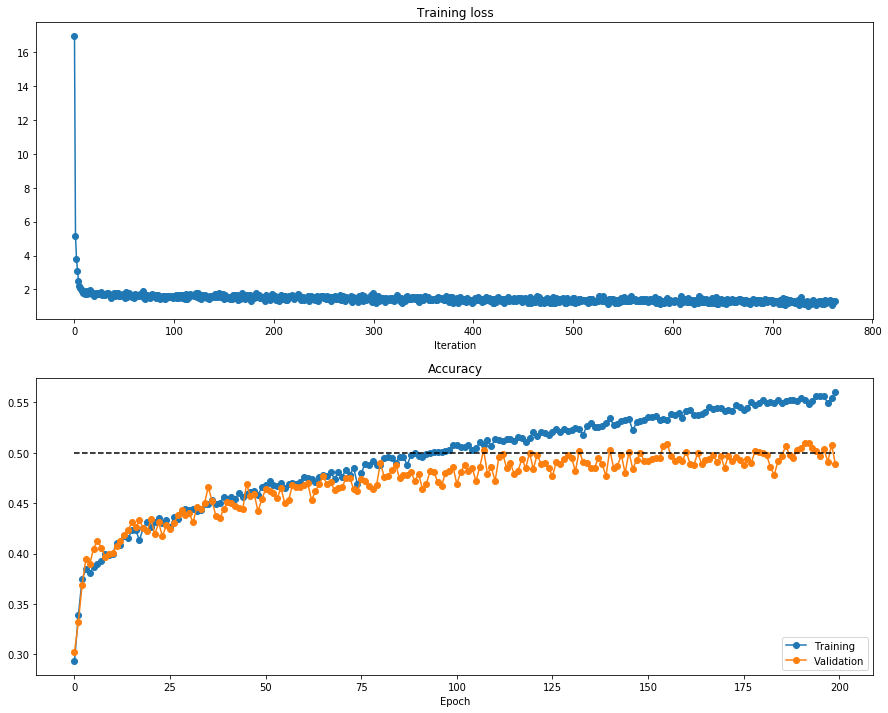

In [8]:
# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100] # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.plot([0.5] * len(val_acc_hist), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## Different Optimizers
There are several more advanced optimizers than vanilla SGD, you will implement three more sophisticated and widely-used methods in this section. Please complete the TODOs in the optim.py under lib directory.

## SGD + Momentum
The update rule of SGD plus momentum is as shown below: <br\ >
\begin{equation}
v_t: velocity \\
\gamma: momentum \\
\eta: learning\ rate \\
v_t = \gamma v_{t-1} + \eta \nabla_{\theta}J(\theta) \\
\theta = \theta - v_t
\end{equation}
Complete the SGDM() function in optim.py

In [11]:
# SGD with momentum
model = TinyNet()
loss_f = cross_entropy()
optimizer = SGD(model.net, 1e-4)

In [12]:
# Test the implementation of SGD with Momentum
N, D = 4, 5
test_sgd = sequential(fc(N, D, name="sgd_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

test_sgd.layers[0].params = {"sgd_fc_w": w}
test_sgd.layers[0].grads = {"sgd_fc_w": dw}

test_sgd_momentum = SGDM(test_sgd, 1e-3, 0.9)
test_sgd_momentum.velocity = {"sgd_fc_w": v}
test_sgd_momentum.step()

updated_w = test_sgd.layers[0].params["sgd_fc_w"]
velocity = test_sgd_momentum.velocity["sgd_fc_w"]

expected_updated_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print 'updated_w error: ', rel_error(updated_w, expected_updated_w)
print 'velocity error: ', rel_error(expected_velocity, velocity)

updated_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Run the following code block to train a multi-layer fully connected network with both SGD and SGD plus Momentum. The network trained with SGDM optimizer should converge faster.

Training with Vanilla SGD...
(Iteration 1 / 200) loss: 2.91167306433
(Epoch 1 / 5) Training Accuracy: 0.29125, Validation Accuracy: 0.235
(Epoch 2 / 5) Training Accuracy: 0.33375, Validation Accuracy: 0.273
(Iteration 101 / 200) loss: 1.85114655294
(Epoch 3 / 5) Training Accuracy: 0.382, Validation Accuracy: 0.285
(Epoch 4 / 5) Training Accuracy: 0.41575, Validation Accuracy: 0.3
(Epoch 5 / 5) Training Accuracy: 0.43325, Validation Accuracy: 0.318

Training with SGD plus Momentum...
(Iteration 1 / 200) loss: 2.76490807361
(Epoch 1 / 5) Training Accuracy: 0.2765, Validation Accuracy: 0.253
(Epoch 2 / 5) Training Accuracy: 0.35925, Validation Accuracy: 0.322
(Iteration 101 / 200) loss: 1.61218345882
(Epoch 3 / 5) Training Accuracy: 0.4145, Validation Accuracy: 0.331
(Epoch 4 / 5) Training Accuracy: 0.49125, Validation Accuracy: 0.361
(Epoch 5 / 5) Training Accuracy: 0.49225, Validation Accuracy: 0.384


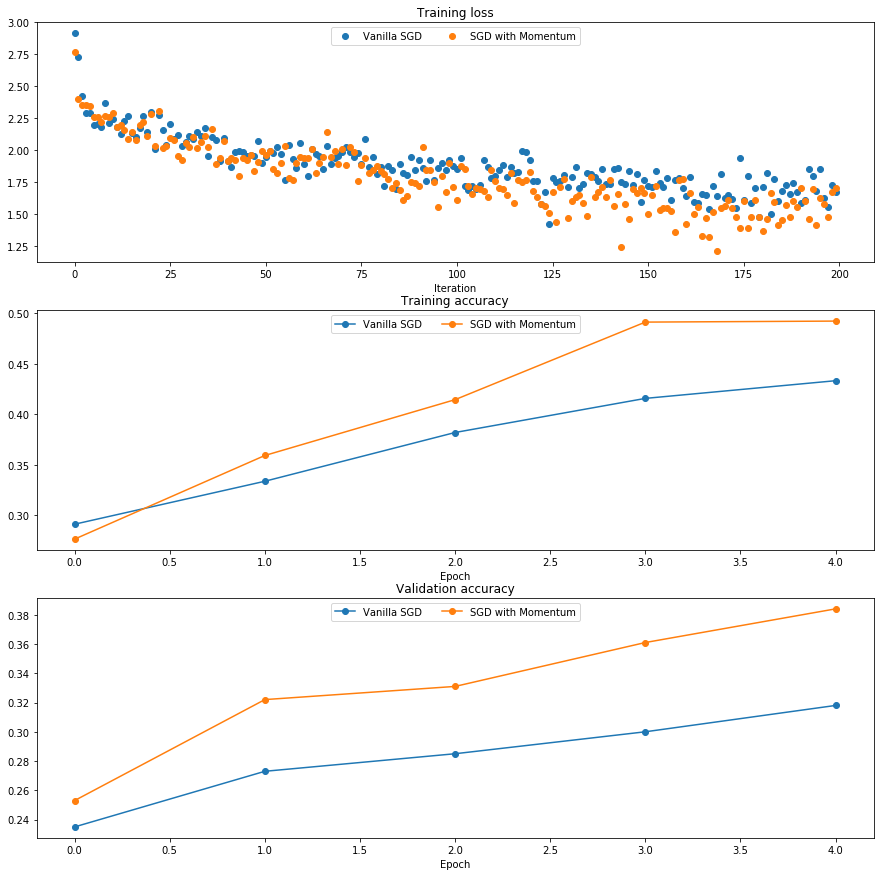

In [9]:
# Arrange a small data
num_train = 4000
small_data_dict = {
    "data_train": (data["data_train"][:num_train], data["labels_train"][:num_train]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

model_sgd      = FullyConnectedNetwork()
model_sgdm     = FullyConnectedNetwork()
loss_f_sgd     = cross_entropy()
loss_f_sgdm    = cross_entropy()
optimizer_sgd  = SGD(model_sgd.net, 1e-2)
optimizer_sgdm = SGDM(model_sgdm.net, 1e-2, 0.9)

print "Training with Vanilla SGD..."
results_sgd = train_net(small_data_dict, model_sgd, loss_f_sgd, optimizer_sgd, batch_size=100, 
                        max_epochs=5, show_every=100, verbose=True)

print "\nTraining with SGD plus Momentum..."
results_sgdm = train_net(small_data_dict, model_sgdm, loss_f_sgdm, optimizer_sgdm, batch_size=100, 
                         max_epochs=5, show_every=100, verbose=True)

opt_params_sgd,  loss_hist_sgd,  train_acc_hist_sgd,  val_acc_hist_sgd  = results_sgd
opt_params_sgdm, loss_hist_sgdm, train_acc_hist_sgdm, val_acc_hist_sgdm = results_sgdm

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdm, 'o', label="SGD with Momentum")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdm, '-o', label="SGD with Momentum")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdm, '-o', label="SGD with Momentum")
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## RMSProp
The update rule of RMSProp is as shown below: <br\ >
\begin{equation}
\gamma: decay\ rate \\
\epsilon: small\ number \\
g_t^2: squared\ gradients \\
\eta: learning\ rate \\
E[g^2]_t: decaying\ average\ of\ past\ squared\ gradients\ at\ update\ step\ t \\
E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 \\
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t+\epsilon}}
\end{equation}
Complete the RMSProp() function in optim.py

In [15]:
# Test RMSProp implementation; you should see errors less than 1e-7
N, D = 4, 5
test_rms = sequential(fc(N, D, name="rms_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

test_rms.layers[0].params = {"rms_fc_w": w}
test_rms.layers[0].grads = {"rms_fc_w": dw}

opt_rms = RMSProp(test_rms, 1e-2, 0.99)
opt_rms.cache = {"rms_fc_w": cache}
opt_rms.step()

updated_w = test_rms.layers[0].params["rms_fc_w"]
cache = opt_rms.cache["rms_fc_w"]

expected_updated_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print 'updated_w error: ', rel_error(expected_updated_w, updated_w)
print 'cache error: ', rel_error(expected_cache, opt_rms.cache["rms_fc_w"])

updated_w error:  9.50264522989e-08
cache error:  2.64779558072e-09


## Adam
The update rule of Adam is as shown below: <br\ >
\begin{equation}
g_t: gradients\ at\ update\ step\ t \\
m_t = \beta_1m_{t-1} + (1-\beta_1)g_t \\
v_t = \beta_2v_{t-1} + (1-\beta_1)g_t^2 \\
\hat{m_t}: bias\ corrected\ m_t \\
\hat{v_t}: bias\ corrected\ v_t \\
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v_t}}+\epsilon}
\end{equation}
Complete the Adam() function in optim.py

In [16]:
# Test Adam implementation; you should see errors around 1e-7 or less
N, D = 4, 5
test_adam = sequential(fc(N, D, name="adam_fc"))

w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

test_adam.layers[0].params = {"adam_fc_w": w}
test_adam.layers[0].grads = {"adam_fc_w": dw}

opt_adam = Adam(test_adam, 1e-2, 0.9, 0.999, t=5)
opt_adam.mt = {"adam_fc_w": m}
opt_adam.vt = {"adam_fc_w": v}
opt_adam.step()

updated_w = test_adam.layers[0].params["adam_fc_w"]
mt = opt_adam.mt["adam_fc_w"]
vt = opt_adam.vt["adam_fc_w"]

expected_updated_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print 'updated_w error: ', rel_error(expected_updated_w, updated_w)
print 'mt error: ', rel_error(expected_m, mt)
print 'vt error: ', rel_error(expected_v, vt)

updated_w error:  1.13956917985e-07
mt error:  4.21496319311e-09
vt error:  4.20831403811e-09


## Comparing the optimizers
Run the following code block to compare the plotted results among all the above optimizers

Training with RMSProp...
(Iteration 1 / 200) loss: 2.50854932183
(Epoch 1 / 5) Training Accuracy: 0.3295, Validation Accuracy: 0.272
(Epoch 2 / 5) Training Accuracy: 0.43025, Validation Accuracy: 0.359
(Iteration 101 / 200) loss: 1.65654160197
(Epoch 3 / 5) Training Accuracy: 0.4935, Validation Accuracy: 0.378
(Epoch 4 / 5) Training Accuracy: 0.548, Validation Accuracy: 0.372
(Epoch 5 / 5) Training Accuracy: 0.59175, Validation Accuracy: 0.384

Training with Adam...
(Iteration 1 / 200) loss: 2.55570500666
(Epoch 1 / 5) Training Accuracy: 0.3295, Validation Accuracy: 0.29
(Epoch 2 / 5) Training Accuracy: 0.43125, Validation Accuracy: 0.339
(Iteration 101 / 200) loss: 1.65244610354
(Epoch 3 / 5) Training Accuracy: 0.4765, Validation Accuracy: 0.361
(Epoch 4 / 5) Training Accuracy: 0.50925, Validation Accuracy: 0.367
(Epoch 5 / 5) Training Accuracy: 0.55825, Validation Accuracy: 0.37


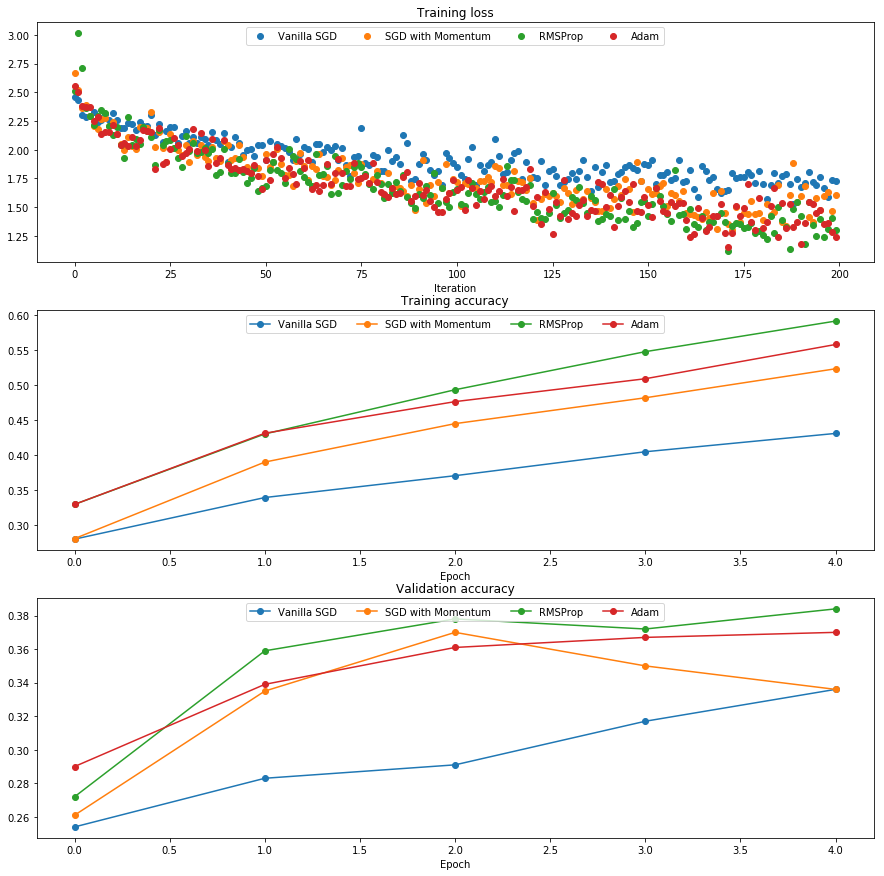

In [19]:
model_rms      = FullyConnectedNetwork()
model_adam     = FullyConnectedNetwork()
loss_f_rms     = cross_entropy()
loss_f_adam    = cross_entropy()
optimizer_rms  = RMSProp(model_rms.net, 5e-4)
optimizer_adam = Adam(model_adam.net, 5e-4)

print "Training with RMSProp..."
results_rms = train_net(small_data_dict, model_rms, loss_f_rms, optimizer_rms, batch_size=100, 
                        max_epochs=5, show_every=100, verbose=True)

print "\nTraining with Adam..."
results_adam = train_net(small_data_dict, model_adam, loss_f_adam, optimizer_adam, batch_size=100, 
                         max_epochs=5, show_every=100, verbose=True)

opt_params_rms,  loss_hist_rms,  train_acc_hist_rms,  val_acc_hist_rms  = results_rms
opt_params_adam, loss_hist_adam, train_acc_hist_adam, val_acc_hist_adam = results_adam

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgd, 'o', label="Vanilla SGD")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgd, '-o', label="Vanilla SGD")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgd, '-o', label="Vanilla SGD")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_sgdm, 'o', label="SGD with Momentum")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_sgdm, '-o', label="SGD with Momentum")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_sgdm, '-o', label="SGD with Momentum")

plt.subplot(3, 1, 1)
plt.plot(loss_hist_rms, 'o', label="RMSProp")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_rms, '-o', label="RMSProp")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_rms, '-o', label="RMSProp")
         
plt.subplot(3, 1, 1)
plt.plot(loss_hist_adam, 'o', label="Adam")
plt.subplot(3, 1, 2)
plt.plot(train_acc_hist_adam, '-o', label="Adam")
plt.subplot(3, 1, 3)
plt.plot(val_acc_hist_adam, '-o', label="Adam")
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Training a Network with Dropout
Run the following code blocks to compare the results with and without dropout

In [9]:
# Train two identical nets, one with dropout and one without
num_train = 500
data_dict_500 = {
    "data_train": (data["data_train"][:num_train], data["labels_train"][:num_train]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

solvers = {}
dropout_ps = [0, 0.25, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]  # you can try some dropout prob yourself

results_dict = {}
for dropout_p in dropout_ps:
    results_dict[dropout_p] = {}

for dropout_p in dropout_ps:
    print "Dropout =", dropout_p
    model = DropoutNetTest(dropout_p=dropout_p)
    loss_f = cross_entropy()
    optimizer = SGDM(model.net, 1e-4)
    results = train_net(data_dict_500, model, loss_f, optimizer, batch_size=100, 
                        max_epochs=20, show_every=100, verbose=True)
    opt_params, loss_hist, train_acc_hist, val_acc_hist = results
    results_dict[dropout_p] = {
        "opt_params": opt_params, 
        "loss_hist": loss_hist, 
        "train_acc_hist": train_acc_hist, 
        "val_acc_hist": val_acc_hist
    }

Dropout = 0
(Iteration 1 / 100) loss: 2.47185397787
(Epoch 1 / 20) Training Accuracy: 0.146, Validation Accuracy: 0.141
(Epoch 2 / 20) Training Accuracy: 0.148, Validation Accuracy: 0.147
(Epoch 3 / 20) Training Accuracy: 0.168, Validation Accuracy: 0.151
(Epoch 4 / 20) Training Accuracy: 0.178, Validation Accuracy: 0.156
(Epoch 5 / 20) Training Accuracy: 0.19, Validation Accuracy: 0.169
(Epoch 6 / 20) Training Accuracy: 0.206, Validation Accuracy: 0.179
(Epoch 7 / 20) Training Accuracy: 0.216, Validation Accuracy: 0.191
(Epoch 8 / 20) Training Accuracy: 0.224, Validation Accuracy: 0.195
(Epoch 9 / 20) Training Accuracy: 0.24, Validation Accuracy: 0.199
(Epoch 10 / 20) Training Accuracy: 0.252, Validation Accuracy: 0.204
(Epoch 11 / 20) Training Accuracy: 0.26, Validation Accuracy: 0.209
(Epoch 12 / 20) Training Accuracy: 0.274, Validation Accuracy: 0.207
(Epoch 13 / 20) Training Accuracy: 0.284, Validation Accuracy: 0.215
(Epoch 14 / 20) Training Accuracy: 0.292, Validation Accuracy: 

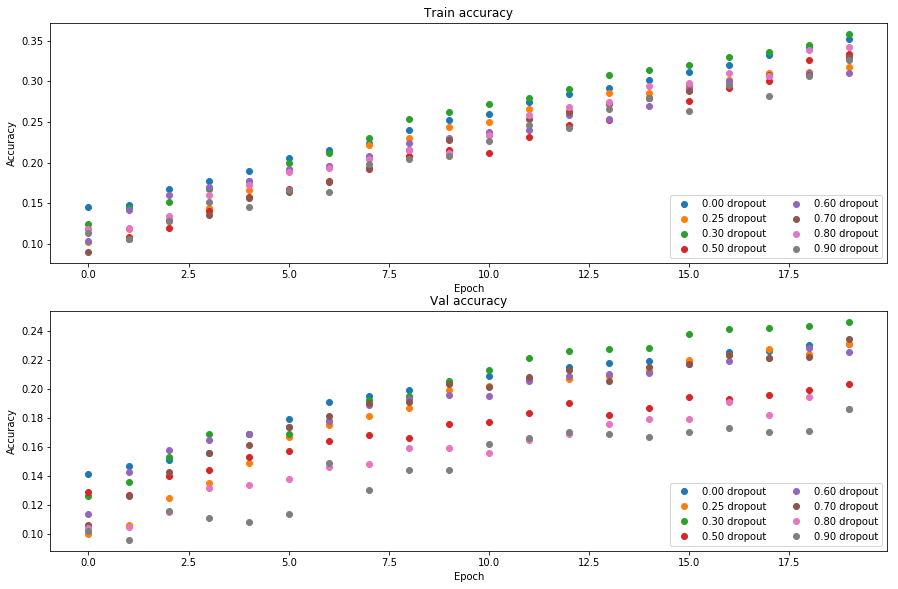

In [10]:
# Plot train and validation accuracies of the two models
train_accs = []
val_accs = []
for dropout_p in dropout_ps:
    curr_dict = results_dict[dropout_p]
    train_accs.append(curr_dict["train_acc_hist"][-1])
    val_accs.append(curr_dict["val_acc_hist"][-1])

plt.subplot(3, 1, 1)
for dropout_p in dropout_ps:
    curr_dict = results_dict[dropout_p]
    plt.plot(curr_dict["train_acc_hist"], 'o', label='%.2f dropout' % dropout_p)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout_p in dropout_ps:
    curr_dict = results_dict[dropout_p]
    plt.plot(curr_dict["val_acc_hist"], 'o', label='%.2f dropout' % dropout_p)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

### Inline Question: Describe what you observe from the above results and graphs
#### Ans: For the given dataset, Adam and RMSProp optimisers seems to work well achieving higher accuracy by minimising the loss almost to the same value, though RMSProp seems to be the best compared to other optimizers.  For graphs related to dropout, increasing the dropout rate to a very high value decreases the accuracy as higher number of nodes are turned off which is as expected. Our model achieves highest training and validation accuracies with a dropout rate of 0.3.

## Plot the Activation Functions
In each of the activation function, use the given lambda function template to plot their corresponding curves.

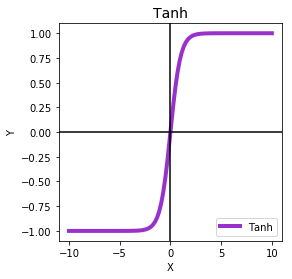

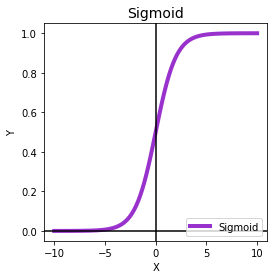

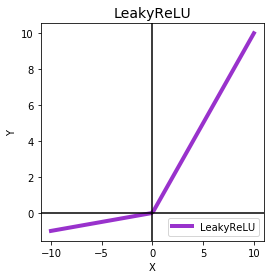

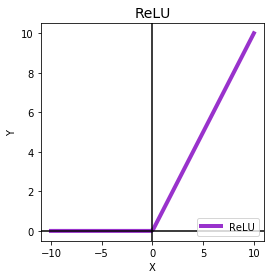

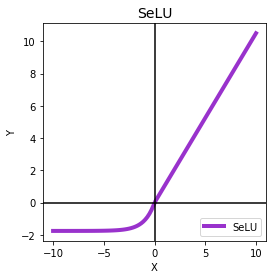

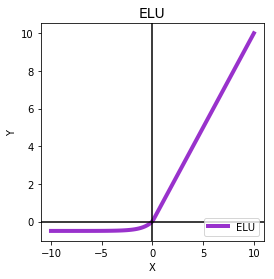

In [51]:
left, right = -10, 10
X  = np.linspace(left, right, 100)
XS = np.linspace(-5, 5, 10)
lw = 4
alpha = 0.1
elu_alpha = 0.5
selu_alpha = 1.6732
selu_scale = 1.0507

#########################
####### YOUR CODE #######
#########################
sigmoid = lambda x: 1 / (1 + np.exp(-x))
leaky_relu = lambda x: np.where(x<0,alpha*x,x)
relu = lambda x: np.where(x<0,0,x)
elu = lambda x: np.where(x<0,elu_alpha*(np.exp(x)-1),x)
selu = lambda x: selu_scale*np.where(x<0,selu_alpha*(np.exp(x)-1),x)
tanh = lambda x: np.tanh(x)
#########################
### END OF YOUR CODE ####
#########################

activations = {
    "Sigmoid": sigmoid,
    "LeakyReLU": leaky_relu,
    "ReLU": relu,
    "ELU": elu,
    "SeLU": selu,
    "Tanh": tanh
}

# Ground Truth activations
GT_Act = {
    "Sigmoid": [0.00669285092428, 0.0200575365379, 0.0585369028744, 0.158869104881, 0.364576440742, 
                0.635423559258, 0.841130895119, 0.941463097126, 0.979942463462, 0.993307149076],
    "LeakyReLU": [-0.5, -0.388888888889, -0.277777777778, -0.166666666667, -0.0555555555556, 
                  0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "ReLU": [-0.0, -0.0, -0.0, -0.0, -0.0, 0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "ELU": [-0.4966310265, -0.489765962143, -0.468911737989, -0.405562198581, -0.213123289631, 
            0.555555555556, 1.66666666667, 2.77777777778, 3.88888888889, 5.0],
    "SeLU": [-1.74618571868, -1.72204772347, -1.64872296837, -1.42598202974, -0.749354802287, 
             0.583722222222, 1.75116666667, 2.91861111111, 4.08605555556, 5.2535],
    "Tanh": [-0.999909204263, -0.999162466631, -0.992297935288, -0.931109608668, -0.504672397722, 
             0.504672397722, 0.931109608668, 0.992297935288, 0.999162466631, 0.999909204263]
} 

for label in activations:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(X, activations[label](X), color='darkorchid', lw=lw, label=label)
    assert rel_error(activations[label](XS), GT_Act[label]) < 1e-9, \
           "Your implementation of {} might be wrong".format(label)
    ax.legend(loc="lower right")
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title('{}'.format(label), fontsize=14)
    plt.xlabel(r"X")
    plt.ylabel(r"Y")
    plt.show()

# Phew! You're done for problem 1 now, but 3 more to go... LOL